# Generate kernels using locally hosted LLM

There are many reasons for hosting your own LLM endpoint: privacy, latency, reliability, customization, etc. Your RyzenAI machine comes with an GPU more than capable of running local LLMs. This notebook will demonstrate how to host your own endpoint and use it to generate kernels for the NPU.

## Goals
* Use Ollama server to host a small 1B parameter model
* Generate solutions using AIECoder code generator by pointing to the local endpoint
* Test the generated kernels

## References
* https://ollama.com
* https://github.com/QwenLM/Qwen2.5-Coder

## Setup Ollama

Open a separate terminal window install and start the ollama server.

```bash
curl -fsSL https://ollama.com/install.sh | sh
ollama serve
```

Use another terminal screen to pull in a model you want to use. For example, here we'll download the small Qwen-2.5-coder 7B model.

```bash
ollama pull qwen2.5-coder:7b
```

Once that is done you're ready to start using your LLM locally. Your server will be available at 127.0.0.1:11434. But to access the endpoint you need to use http, so your base_url becomes `http://localhost:11434/v1`.

## Generate code using local endpoint

We are using the same functions as before, but this time changing the `base_url` to our locally hosted LLM server.  

In [1]:
from npueval import dataset
from npueval.aiecoder import AIECoder

# Load a single kernel test sample
test = dataset.get_by_name('add_offset_int8')

# Create coder pointing to our local endpoint
coder = AIECoder(model="qwen2.5-coder:7b", base_url="http://localhost:11434/v1", api_key="aaa")

# No retries, just print a response
response = coder(test['prompt'])
for msg in response['history']:
    print(msg['role'])
    print(msg['content'])

system
You are a part of a code generation system for AIE (AI Engines).

* Your job is to write C++ code for a single kernel that will run on an AIE tile.
* Produce only the C++ code for the requested kernel including any required headers and imports.
* Make sure the C++ code is complete and self contained in a single code block.
* Name the function exactly as specified in the request, and output only the kernel (no main(), examples, explanations or extra code).

user
/*
This AIE kernel adds a scalar int8 offset to every element of the input int8_t vector (length 256), and writes the result to the output buffer.
>>> add_offset_int8([72, -53, 17, 92, -33, 95, 3, -91], -11)
[61, -64, 6, 81, -44, 84, -8, -102]
This kernel should be optimized for the following input/output buffer shapes and parameters:
in_buffer size: 256
out_buffer size: 256
offset: -11
*/
#include <aie_api/aie.hpp>
#include "aie_kernel_utils.h"

void add_offset_int8(int8_t *in_buffer, int8_t *out_buffer, int8_t offset) {

In [2]:
from pathlib import Path
import json

tests = dataset[:5]

model = "qwen2.5-coder:7b"
results_path = Path("results")

def generate_one_completion(prompt, model="gpt-4o-mini", base_url=None, attempts=2, api_key=None):
    coder = AIECoder(model=model, base_url=base_url, attempts=attempts, api_key=api_key)
    response = coder(prompt)
    
    result = {
        "code": coder.extract_codeblock(response['response']),
        "stats": {"token_usage": response['token_usage'],
                  "history": response['history']}
    }

    return result

# For each model generate a solution in the local results path
print(f"Generating solutions for {model}")
solutions_path = results_path / "solutions" / model
solutions_path.mkdir(parents=True, exist_ok=True)

for test in tests:
    print(f"Generating solution for {test['kernel_name']}")
    response = generate_one_completion(test['prompt'], model=model, base_url="http://localhost:11434/v1", api_key="aaa")
    
    solution_file = solutions_path / f"{test['kernel_name']}.json"
    with solution_file.open('w') as file:
        json.dump(response, file, indent=4)

Generating solutions for qwen2.5-coder:7b
Generating solution for abs_int8
Generating solution for add_offset_int8
Generating solution for add_offset_uint8
Generating solution for argmax_bfloat16
Generating solution for argmax_int32


In [3]:
from npueval import run_functional_tests

solutions_path = results_path / "solutions" / model
evals_path = results_path / "evaluations" / model
run_functional_tests(tests, solutions_path, results_path=evals_path, overwrite=True, verbose=False)


Kernel: abs_int8_wrapper
results/evaluations/qwen2.5-coder:7b/abs_int8_wrapper.mlir generated successfully
abs_int8_wrapper.xclbin, abs_int8_wrapper.bin built
Trace written to results/evaluations/qwen2.5-coder:7b/abs_int8_wrapper_trace.json
Result: Pass

Kernel: add_offset_int8_wrapper
results/evaluations/qwen2.5-coder:7b/add_offset_int8_wrapper.mlir generated successfully
add_offset_int8_wrapper.xclbin, add_offset_int8_wrapper.bin built
Trace written to results/evaluations/qwen2.5-coder:7b/add_offset_int8_wrapper_trace.json
Result: Pass

Kernel: add_offset_uint8_wrapper
results/evaluations/qwen2.5-coder:7b/add_offset_uint8_wrapper.mlir generated successfully
add_offset_uint8_wrapper.xclbin, add_offset_uint8_wrapper.bin built
Trace written to results/evaluations/qwen2.5-coder:7b/add_offset_uint8_wrapper_trace.json
Result: Pass

Kernel: argmax_bfloat16_wrapper
results/evaluations/qwen2.5-coder:7b/argmax_bfloat16_wrapper.mlir generated successfully
argmax_bfloat16_wrapper.xclbin, argmax

## Comparing with other models

We can re-use the results we obtain from the previous notebooks to compare how well our self-hosted alternative did. We'll copy-paste the post-processing from [02_evaluating_solutions](./02_evaluating_solutions.ipynb) with the only change being the addition of the qwen2.5-coder model to the list.

In [4]:
models = ['qwen2.5-coder:7b', 'gpt-4o-mini', 'gpt-4.1']

scores = {}
for model in models:
    print(f"\nProcessing {model}")
    functional_score = total_cycles = vector_score = 0
    
    for test in tests:
        with open(results_path / "evaluations" / model / f"{test['kernel_name']}_wrapper.json") as f:
            data = json.load(f)
            if data['result'] == 'Pass':
                print(f"{test['kernel_name']}: total_cycles={data['total_cycles']}, vector_cycles={data['vector_cycles']}")
                functional_score += 1
                total_cycles += data['total_cycles']
                vector_score += data['vector_score']
    
    scores[model] = {
        'functional_score': functional_score / len(tests)*100,
        'avg_cycles': total_cycles / functional_score, # divide by number of passing kernels
        'avg_vector_score': vector_score / len(tests)*100
    }


Processing qwen2.5-coder:7b
abs_int8: total_cycles=9990, vector_cycles=0
add_offset_int8: total_cycles=2502, vector_cycles=0
add_offset_uint8: total_cycles=9990, vector_cycles=0
argmax_bfloat16: total_cycles=616, vector_cycles=63
argmax_int32: total_cycles=1792, vector_cycles=0

Processing gpt-4o-mini
abs_int8: total_cycles=9990, vector_cycles=0
add_offset_int8: total_cycles=2502, vector_cycles=0
add_offset_uint8: total_cycles=9990, vector_cycles=0
argmax_bfloat16: total_cycles=616, vector_cycles=63
argmax_int32: total_cycles=1792, vector_cycles=0

Processing gpt-4.1
abs_int8: total_cycles=540, vector_cycles=31
argmax_int32: total_cycles=1351, vector_cycles=0


## Visualizing results

Now we can see that on our small sample of 5 kernels the open source model actually matches gpt-4o-mini in performance. Note that this is a very small model that you can easily fit on your Ryzen AI device - experiment indefinitely with no subscriptions or need to buy more tokens.

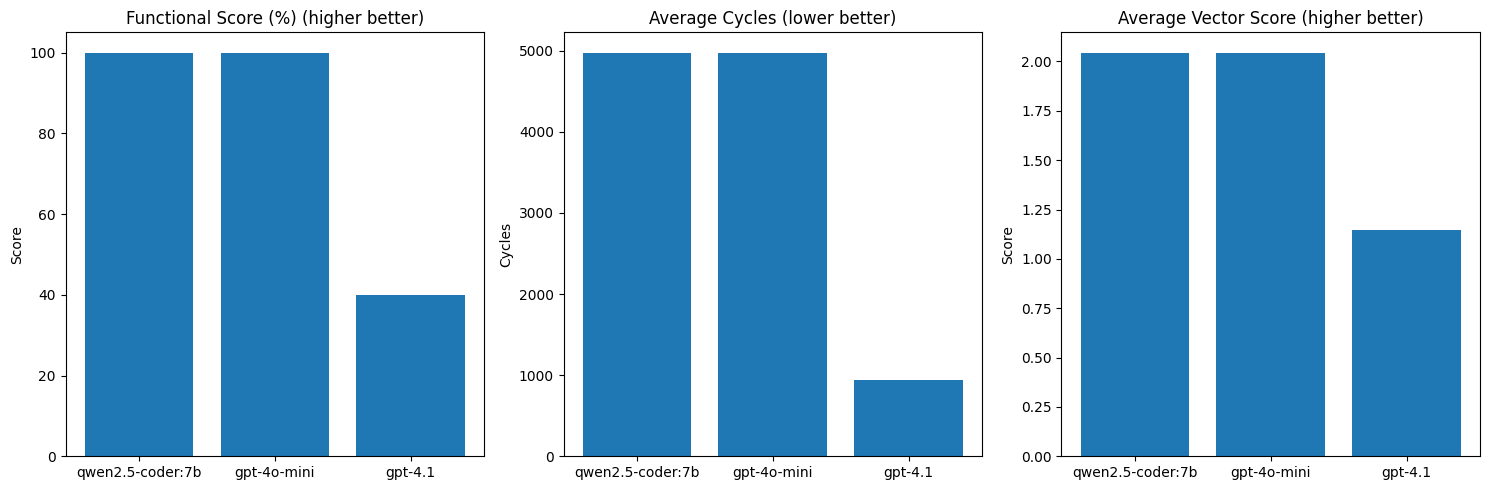

In [5]:
import matplotlib.pyplot as plt

models = list(scores.keys())
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Functional correctness
functional = [scores[model]['functional_score'] for model in models]
axes[0].bar(models, functional)
axes[0].set_title('Functional Score (%) (higher better)')
axes[0].set_ylabel('Score')

# Average runtime cycles
cycles = [scores[model]['avg_cycles'] for model in models]
axes[1].bar(models, cycles)
axes[1].set_title('Average Cycles (lower better)')
axes[1].set_ylabel('Cycles')

# Vector score
vector = [scores[model]['avg_vector_score'] for model in models]
axes[2].bar(models, vector)
axes[2].set_title('Average Vector Score (higher better)')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

-----
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT 